In [19]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import geopy.distance

In [3]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
import python_lib.viz as my_viz
import python_lib.utils as my_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
request_path = '../test_data/inputs/medium_test_1/request.json'
request = my_utils.read_json(request_path)

In [14]:
model = KMeans(n_clusters=len(request['vehicles']))

X = np.array([
    [location['point']['lon'], location['point']['lat']]
    for location in request['locations']
])

clusters = model.fit_predict(X)

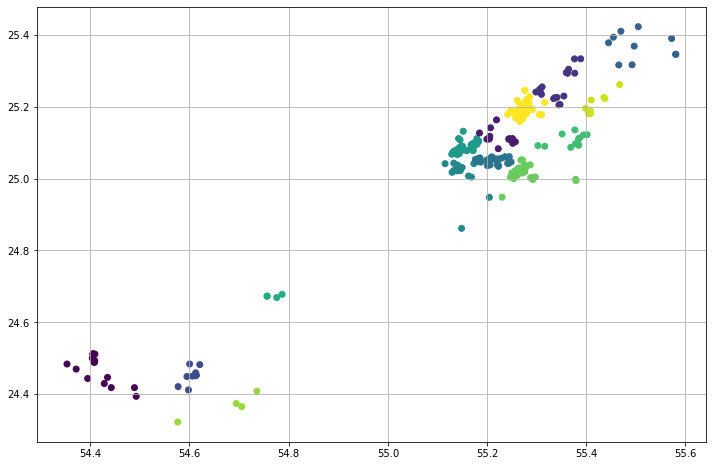

In [17]:
plt.figure(figsize=(12, 8))
plt.scatter(X[:, 0], X[:, 1], c=clusters)
plt.grid(visible=True)
plt.show()

In [38]:
def get_distance_between_two_points(lat1, lon1, lat2, lon2):
    coords_1 = [lat1, lon1]
    coords_2 = [lat2, lon2]
    return geopy.distance.geodesic(coords_1, coords_2).m


def get_greedy_routes(request, clusters):
    assert len(request['vehicles']) <= max(clusters) + 1
    assert len(clusters) == len(request['locations'])
    
    location_id_to_location = {
        location['id']: location for location in request['locations']
    }
    
    routes = []
    
    for cluster_number, vehicle in enumerate(request['vehicles']):
        location_ids_to_visit = set([location['id'] for current_cluster_number, location in zip(clusters, request['locations']) if current_cluster_number == cluster_number])
        
        route = {
            'vehicle_id': vehicle['id'],
            'location_ids': []
        }
        
        assert len(request['depots']) == 1
        previous_location_point = request['depots'][0]['point']
        
        while len(location_ids_to_visit) > 0:
            lat1 = previous_location_point['lat']
            lon1 = previous_location_point['lon']
            
            next_location = None
            min_distance = None
            
            for potential_next_location_id in location_ids_to_visit:
                potential_next_location = location_id_to_location[potential_next_location_id]
                lat2 = potential_next_location['point']['lat']
                lon2 = potential_next_location['point']['lon']
                current_distance = get_distance_between_two_points(lat1, lon1, lat2, lon2)
                if next_location is None or current_distance < min_distance:
                    next_location = potential_next_location
                    min_distance = current_distance
            
            route['location_ids'].append(next_location['id'])
            previous_location_point = next_location['point']
            location_ids_to_visit.discard(next_location['id'])
        
        routes.append(route)
        
    return routes

In [39]:
greedy_routes = get_greedy_routes(request, clusters)

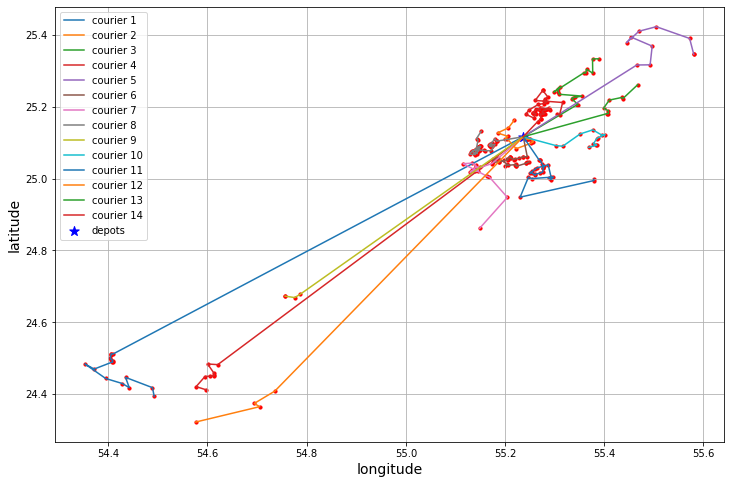

In [40]:
my_viz.plot_routes(request, greedy_routes)